<div align="center">
  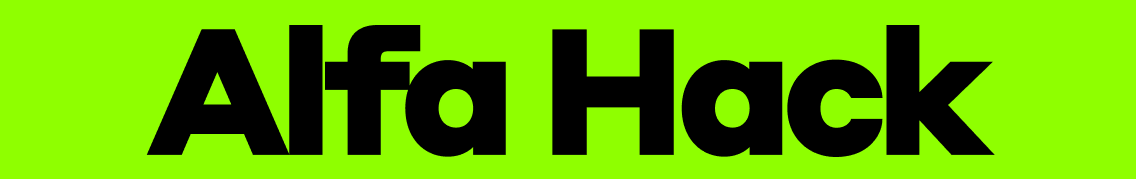
</div>

## Установка библиотек и импорт данных

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from collections import Counter

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

import optuna

from warnings import filterwarnings
filterwarnings('ignore')

Подключаемся в Google Drive, чтобы работать с файлами из Google Colaboratory

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Эксперименты с моделями на разных данных

## Загрузка данных

###  1. Без выбросов (замена на медиану по признаку)

In [ ]:
train_no_outliers = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/train (train val) processed/train_no_outliers.csv').drop('Unnamed: 0', axis=1)
val_no_outliers = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/val (train val) processed/val_raw.csv').drop('Unnamed: 0', axis=1)

In [ ]:
train_no_outliers.head()

,id,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,...,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_396_1.0,feature_396_2.0,feature_411_0.0,feature_411_1.0,target
0,18528,-0.929533,-0.087657,-0.266736,-0.325690,-0.737559,-0.764311,-1.363869,-0.472380,1.304781,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
1,25985,-1.610432,-1.159588,-0.263746,-0.530598,-1.434444,-0.750561,-1.157461,-1.878024,0.187424,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
2,16308,0.666124,-1.828877,-1.549235,-0.768044,-0.849521,1.462194,0.492319,-0.358055,0.396696,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,36645,-2.497979,-1.402859,-0.752793,1.639469,-0.702706,-0.771861,1.122613,0.386784,0.850490,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
4,32358,-0.327321,0.479599,0.741337,0.702061,1.382356,0.323255,-0.288256,-1.055095,0.950498,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


In [ ]:
val_no_outliers.head()

,id,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,...,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_396_1.0,feature_396_2.0,feature_411_0.0,feature_411_1.0,target
0,10506,0.947228,-0.410224,-0.827103,1.739426,0.341692,-0.406951,-0.781042,-0.138539,-0.470705,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
1,21940,1.660750,1.763484,0.227845,-1.029927,2.262094,-0.082030,0.194397,0.136751,0.035732,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,35053,-1.831895,0.482104,-0.084190,-1.989204,0.167984,-1.174321,0.822146,0.057873,1.282153,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0
3,6498,-1.713881,-0.798524,0.270740,-0.664812,-1.469914,0.322742,-0.745313,1.077375,0.234416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,24001,-1.214475,-0.784261,0.914069,1.118100,1.123004,0.044097,0.975739,0.581661,-1.460262,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


In [ ]:
X_train_no_outliers = train_no_outliers.drop(['id', 'target'], axis=1)
y_train_no_outliers = train_no_outliers['target']
X_val_no_outliers = val_no_outliers.drop(['id', 'target'], axis=1)
y_val_no_outliers = val_no_outliers['target']

### 2. Без признаков с мультиколлинеарностью

In [ ]:
train_no_multi = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/train (train val) processed/train_no_multi.csv').drop('Unnamed: 0', axis=1)
val_no_multi = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/val (train val) processed/val_no_multi.csv').drop('Unnamed: 0', axis=1)

In [ ]:
train_no_multi.head()

,id,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,...,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_411_0.0,feature_411_1.0,target
0,18528,-0.929533,-0.087657,-0.266736,-0.325690,-0.737559,-0.764311,-1.363869,-0.472380,1.304781,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,25985,-1.610432,-1.159588,-0.263746,-0.530598,-1.434444,-0.750561,-1.157461,-1.878024,0.187424,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
2,16308,0.666124,-1.828877,-1.549235,-0.768044,-0.849521,1.462194,0.492319,-0.358055,0.396696,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
3,36645,-2.497979,-1.402859,-0.752793,1.639469,-0.702706,-0.771861,1.122613,0.386784,0.850490,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
4,32358,-0.327321,0.479599,0.741337,0.702061,1.382356,0.323255,-0.288256,-1.055095,0.950498,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [ ]:
val_no_multi.head()

,id,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,...,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_411_0.0,feature_411_1.0,target
0,10506,0.947228,-0.410224,-0.827103,1.739426,0.341692,-0.406951,-0.781042,-0.138539,-0.470705,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,21940,1.660750,1.763484,0.227845,-1.029927,2.262094,-0.082030,0.194397,0.136751,0.035732,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
2,35053,-1.831895,0.482104,-0.084190,-1.989204,0.167984,-1.174321,0.822146,0.057873,1.282153,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
3,6498,-1.713881,-0.798524,0.270740,-0.664812,-1.469914,0.322742,-0.745313,1.077375,0.234416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,24001,-1.214475,-0.784261,0.914069,1.118100,1.123004,0.044097,0.975739,0.581661,-1.460262,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [ ]:
X_train_no_multi = train_no_multi.drop(['id', 'target'], axis=1)
y_train_no_multi = train_no_multi['target']
X_val_no_multi = val_no_multi.drop(['id', 'target'], axis=1)
y_val_no_multi = val_no_multi['target']

### 3. Без нерелевантных признаков (со значением MI < 0.001)

In [ ]:
train_corr_only = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/train (train val) processed/train_corr_only.csv').drop('Unnamed: 0', axis=1)
val_corr_only = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/val (train val) processed/val_corr_only.csv').drop('Unnamed: 0', axis=1)

In [ ]:
train_corr_only.head()

,id,feature_4,feature_5,feature_7,feature_11,feature_16,feature_19,feature_25,feature_26,feature_29,...,feature_372_4.0,feature_375_0.0,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_396_1.0,feature_396_2.0,target
0,18528,-0.266736,-0.325690,-0.764311,1.304781,-1.410205,-1.095843,0.237337,0.225788,-0.018159,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,25985,-0.263746,-0.530598,-0.750561,0.187424,-0.505030,-0.432017,-1.029793,0.002333,-0.233302,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,16308,-1.549235,-0.768044,1.462194,0.396696,-1.323068,-2.313084,1.726118,-0.586137,-0.452443,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,36645,-0.752793,1.639469,-0.771861,0.850490,-0.918288,0.147519,0.249301,-0.687653,1.037521,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,32358,0.741337,0.702061,0.323255,0.950498,0.743004,1.458129,-2.666020,-0.840406,-1.162312,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
val_corr_only.head()

,id,feature_4,feature_5,feature_7,feature_11,feature_16,feature_19,feature_25,feature_26,feature_29,...,feature_372_4.0,feature_375_0.0,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_396_1.0,feature_396_2.0,target
0,10506,-0.827103,1.739426,-0.406951,-0.470705,-0.069182,0.500486,-0.856685,-0.163864,0.007770,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,21940,0.227845,-1.029927,-0.082030,0.035732,0.534563,1.000036,1.385588,-0.839393,-1.372439,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,35053,-0.084190,-1.989204,-1.174321,1.282153,0.076712,0.526236,-2.485490,-1.180135,-0.424423,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,6498,0.270740,-0.664812,0.322742,0.234416,1.227613,1.108076,1.188680,-0.117438,-0.956419,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,24001,0.914069,1.118100,0.044097,-1.460262,0.664155,0.154222,-1.727494,-2.729278,0.722012,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
X_train_corr_only = train_corr_only.drop(['id', 'target'], axis=1)
y_train_corr_only = train_corr_only['target']
X_val_corr_only = val_corr_only.drop(['id', 'target'], axis=1)
y_val_corr_only = val_corr_only['target']

### 4. Без выбросов, нерелевантных и коррелирующих

In [ ]:
train_all = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/train (train val) processed/train_all_clean.csv').drop('Unnamed: 0', axis=1)
val_all = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/val (train val) processed/val_multicorr.csv').drop('Unnamed: 0', axis=1)

In [ ]:
train_all.head()

,id,feature_4,feature_5,feature_7,feature_11,feature_16,feature_19,feature_25,feature_26,feature_29,...,feature_339_16.0,feature_342_0.0,feature_342_1.0,feature_375_0.0,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,target
0,18528,-0.266736,-0.325690,-0.764311,1.304781,-1.410205,-1.095843,0.237337,0.225788,-0.018159,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,25985,-0.263746,-0.530598,-0.750561,0.187424,-0.505030,-0.432017,-1.029793,0.002333,-0.233302,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,16308,-1.549235,-0.768044,1.462194,0.396696,-1.323068,-2.313084,1.726118,-0.586137,-0.452443,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,36645,-0.752793,1.639469,-0.771861,0.850490,-0.918288,0.147519,0.249301,-0.687653,1.037521,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,32358,0.741337,0.702061,0.323255,0.950498,0.743004,1.458129,-2.666020,-0.840406,-1.162312,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [ ]:
val_all.head()

,id,feature_4,feature_5,feature_7,feature_11,feature_16,feature_19,feature_25,feature_26,feature_29,...,feature_339_16.0,feature_342_0.0,feature_342_1.0,feature_375_0.0,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,target
0,10506,-0.827103,1.739426,-0.406951,-0.470705,-0.069182,0.500486,-0.856685,-0.163864,0.007770,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,21940,0.227845,-1.029927,-0.082030,0.035732,0.534563,1.000036,1.385588,-0.839393,-1.372439,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,35053,-0.084190,-1.989204,-1.174321,1.282153,0.076712,0.526236,-2.485490,-1.180135,-0.424423,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,6498,0.270740,-0.664812,0.322742,0.234416,1.227613,1.108076,1.188680,-0.117438,-0.956419,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,24001,0.914069,1.118100,0.044097,-1.460262,0.664155,0.154222,-1.727494,-2.729278,0.722012,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [ ]:
X_train_all = train_all.drop(['id', 'target'], axis=1)
y_train_all = train_all['target']
X_val_all = val_all.drop(['id', 'target'], axis=1)
y_val_all = val_all['target']

## LightGBM

In [ ]:
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


###  1. Без выбросов (замена на медиану по признаку)

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_no_outliers = LGBMClassifier(**params, random_seed=42).fit(X=X_train_no_outliers, y=y_train_no_outliers,
                                                    eval_set=[(X_val_no_outliers, y_val_no_outliers)],
                                                    eval_metric='auc')

y_pred_no_outliers = light_boosting_no_outliers.predict_proba(X_val_no_outliers)
print(f'ROC-AUC: {roc_auc_score(y_val_no_outliers, y_pred_no_outliers[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97345
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 476
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
ROC-AUC: 0.760774462932885


In [ ]:
def objective(trial):

    params = {
        "objective": "binary",
        "eval_metric": "log_loss",
        "verbosity": -1,
        "n_estimators": 12500,
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 6),
        "early_stopping_round": 300,
        "random_state": 42,
        "num_leaves": trial.suggest_int("num_leaves", 16, 200),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 25, 200),
    }

    model = LGBMClassifier(**params)
    model.fit(X_train_no_outliers, y_train_no_outliers,
              eval_set=[(X_val_no_outliers, y_val_no_outliers)],
              eval_metric='auc'
              )

    y_pred = model.predict_proba(X_val_no_outliers)
    return roc_auc_score(y_val_no_outliers, y_pred[:, 1])


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

[I 2024-11-11 14:00:32,841] A new study created in memory with name: no-name-e58cc539-e53b-42a7-8a24-cf5bc3494e4d
[I 2024-11-11 14:00:46,785] Trial 0 finished with value: 0.6575872672123833 and parameters: {'subsample': 0.4497512766515691, 'learning_rate': 0.19513213291284048, 'colsample_bytree': 0.16764317510542676, 'reg_alpha': 0.170717533728431, 'reg_lambda': 0.235797356823543, 'scale_pos_weight': 4, 'num_leaves': 96, 'max_depth': 18, 'min_child_samples': 140}. Best is trial 0 with value: 0.6575872672123833.
[I 2024-11-11 14:01:09,690] Trial 1 finished with value: 0.7337956660480672 and parameters: {'subsample': 0.9433162931112979, 'learning_rate': 0.06885798579540045, 'colsample_bytree': 0.16484014392104102, 'reg_alpha': 0.07416344770366876, 'reg_lambda': 0.7681269385384419, 'scale_pos_weight': 4, 'num_leaves': 143, 'max_depth': 17, 'min_child_samples': 132}. Best is trial 1 with value: 0.7337956660480672.
[I 2024-11-11 14:01:47,206] Trial 2 finished with value: 0.6435079564275062 

Number of finished trials: 100


In [ ]:
print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

### 2. Без признаков с мультиколлинеарностью

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_no_multi = LGBMClassifier(**params, random_seed=42).fit(X=X_train_no_multi, y=y_train_no_multi,
                                                    eval_set=[(X_val_no_multi, y_val_no_multi)],
                                                    eval_metric='auc')

y_pred_no_multi = light_boosting_no_multi.predict_proba(X_val_no_multi)
print(f'ROC-AUC: {roc_auc_score(y_val_no_multi, y_pred_no_multi[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.310302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96518
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 442
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC-AUC: 0.7632582494711999


### 3. Без нерелевантных признаков

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_corr_only = LGBMClassifier(**params, random_seed=42).fit(X=X_train_corr_only, y=y_train_corr_only,
                                                    eval_set=[(X_val_corr_only, y_val_corr_only)],
                                                    eval_metric='auc')

y_pred_corr_only = light_boosting_corr_only.predict_proba(X_val_corr_only)
print(f'ROC-AUC: {roc_auc_score(y_val_corr_only, y_pred_corr_only[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27949
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC-AUC: 0.7843323593607597


In [ ]:
def objective(trial):

    params = {
        "objective": "binary",
        "eval_metric": "log_loss",
        "verbosity": -1,
        "n_estimators": 12500,
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 6),
        "early_stopping_round": 300,
        "random_state": 42,
        "num_leaves": trial.suggest_int("num_leaves", 16, 200),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 25, 200),
    }

    model = LGBMClassifier(**params)
    model.fit(X_train_corr_only, y_train_corr_only,
              eval_set=[(X_val_corr_only, y_val_corr_only)],
              eval_metric='auc'
              )

    y_pred = model.predict_proba(X_val_corr_only)
    return roc_auc_score(y_val_corr_only, y_pred[:, 1])


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

[I 2024-11-11 21:14:22,864] A new study created in memory with name: no-name-583e776a-f3a6-4887-acf6-72167f85f4d6
[I 2024-11-11 21:14:41,352] Trial 0 finished with value: 0.7681169851984683 and parameters: {'subsample': 0.43930788263204, 'learning_rate': 0.053578161429516546, 'colsample_bytree': 0.34855207913228625, 'reg_alpha': 0.5724077147931426, 'reg_lambda': 0.9768700311564229, 'scale_pos_weight': 6, 'num_leaves': 122, 'max_depth': 13, 'min_child_samples': 142}. Best is trial 0 with value: 0.7681169851984683.
[I 2024-11-11 21:14:51,053] Trial 1 finished with value: 0.712519876725185 and parameters: {'subsample': 0.6677838920324465, 'learning_rate': 0.18474456704242695, 'colsample_bytree': 0.7759389946360525, 'reg_alpha': 0.5583341228862956, 'reg_lambda': 0.42676370162438193, 'scale_pos_weight': 5, 'num_leaves': 162, 'max_depth': 10, 'min_child_samples': 177}. Best is trial 0 with value: 0.7681169851984683.
[I 2024-11-11 21:15:05,569] Trial 2 finished with value: 0.7727006719054638 

Number of finished trials: 100


In [ ]:
print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

Best trial:
Value: 0.7887613092611544
Params: 
subsample: 0.3772358791366265
learning_rate: 0.030489747450469135
colsample_bytree: 0.10741359511640512
reg_alpha: 0.4479577893152193
reg_lambda: 0.619190045098869
scale_pos_weight: 2
num_leaves: 34
max_depth: 20
min_child_samples: 50


In [ ]:
params = {
    'subsample': 0.3772358791366265,
    'learning_rate': 0.030489747450469135,
    'colsample_bytree': 0.10741359511640512,
    'reg_alpha': 0.4479577893152193,
    'reg_lambda': 0.619190045098869,
    'scale_pos_weight': 2,
    'num_leaves': 34,
    'max_depth': 20,
    'min_child_samples': 50
}

light_boosting_corr_only_best = LGBMClassifier(**params, random_seed=42).fit(X=X_train_corr_only, y=y_train_corr_only,
                                                    eval_set=[(X_val_corr_only, y_val_corr_only)],
                                                    eval_metric='auc')

y_pred_corr_only_best = light_boosting_corr_only_best.predict_proba(X_val_corr_only)
print(f'ROC-AUC: {roc_auc_score(y_val_corr_only, y_pred_corr_only_best[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27957
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
ROC-AUC: 0.7753983081877329


### 4. Без выбросов, нерелевантных и коррелирующих

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_all = LGBMClassifier(**params, random_seed=42).fit(X=X_train_all, y=y_train_all,
                                                    eval_set=[(X_val_all, y_val_all)],
                                                    eval_metric='auc')

y_pred_all = light_boosting_all.predict_proba(X_val_all)
print(f'ROC-AUC: {roc_auc_score(y_val_all, y_pred_all[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27632
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC-AUC: 0.7677087582075706


## CatBoost

###  1. Без выбросов (замена на медиану по признаку)

In [ ]:
params = {
    'iterations': 192,
    'depth': 10,
    'l2_leaf_reg': 8.23039014146229,
    'bootstrap_type': 'Bayesian',
    'random_strength': 0.00021126587495755143,
    'bagging_temperature': 0.16399476224796486,
    'od_type': 'Iter',
    'od_wait': 39
}

cat_boosting_no_outliers = CatBoostClassifier(random_seed=42).fit(X_train_no_outliers, y_train_no_outliers,
                                                      eval_set=(X_val_no_outliers, y_val_no_outliers),
                                                      early_stopping_rounds=20)

y_pred_no_outliers = cat_boosting_no_outliers.predict_proba(X_val_no_outliers)
print(f'ROC-AUC: {roc_auc_score(y_val_no_outliers, y_pred_no_outliers[:, 1])}')

Learning rate set to 0.071597
0:	learn: 0.5685710	test: 0.5686877	best: 0.5686877 (0)	total: 490ms	remaining: 8m 9s
1:	learn: 0.4712751	test: 0.4715507	best: 0.4715507 (1)	total: 770ms	remaining: 6m 24s
2:	learn: 0.3955097	test: 0.3959845	best: 0.3959845 (2)	total: 1.03s	remaining: 5m 42s
3:	learn: 0.3322515	test: 0.3329555	best: 0.3329555 (3)	total: 1.3s	remaining: 5m 24s
4:	learn: 0.2862692	test: 0.2870694	best: 0.2870694 (4)	total: 1.55s	remaining: 5m 8s
5:	learn: 0.2483897	test: 0.2495014	best: 0.2495014 (5)	total: 1.8s	remaining: 4m 58s
6:	learn: 0.2199241	test: 0.2211123	best: 0.2211123 (6)	total: 2.06s	remaining: 4m 52s
7:	learn: 0.1964993	test: 0.1979212	best: 0.1979212 (7)	total: 2.32s	remaining: 4m 48s
8:	learn: 0.1789742	test: 0.1804554	best: 0.1804554 (8)	total: 2.56s	remaining: 4m 41s
9:	learn: 0.1648025	test: 0.1663552	best: 0.1663552 (9)	total: 2.79s	remaining: 4m 36s
10:	learn: 0.1532091	test: 0.1548179	best: 0.1548179 (10)	total: 3.02s	remaining: 4m 31s
11:	learn: 0.14

### 2. Без признаков с мультиколлинеарностью

In [ ]:
params = {
    'iterations': 192,
    'depth': 10,
    'l2_leaf_reg': 8.23039014146229,
    'bootstrap_type': 'Bayesian',
    'random_strength': 0.00021126587495755143,
    'bagging_temperature': 0.16399476224796486,
    'od_type': 'Iter',
    'od_wait': 39
}

cat_boosting_no_multi = CatBoostClassifier(random_seed=42).fit(X_train_no_multi, y_train_no_multi,
                                                      eval_set=(X_val_no_multi, y_val_no_multi),
                                                      early_stopping_rounds=20)

y_pred_no_multi = cat_boosting_no_multi.predict_proba(X_val_no_multi)
print(f'ROC-AUC: {roc_auc_score(y_val_no_multi, y_pred_no_multi[:, 1])}')

Learning rate set to 0.071597
0:	learn: 0.5696880	test: 0.5699283	best: 0.5699283 (0)	total: 326ms	remaining: 5m 25s
1:	learn: 0.4733261	test: 0.4737207	best: 0.4737207 (1)	total: 560ms	remaining: 4m 39s
2:	learn: 0.3972073	test: 0.3977179	best: 0.3977179 (2)	total: 842ms	remaining: 4m 39s
3:	learn: 0.3362107	test: 0.3370009	best: 0.3370009 (3)	total: 1.1s	remaining: 4m 32s
4:	learn: 0.2874798	test: 0.2885519	best: 0.2885519 (4)	total: 1.35s	remaining: 4m 28s
5:	learn: 0.2500509	test: 0.2513708	best: 0.2513708 (5)	total: 1.6s	remaining: 4m 25s
6:	learn: 0.2195346	test: 0.2210743	best: 0.2210743 (6)	total: 1.73s	remaining: 4m 5s
7:	learn: 0.1966529	test: 0.1983317	best: 0.1983317 (7)	total: 1.87s	remaining: 3m 51s
8:	learn: 0.1782043	test: 0.1799687	best: 0.1799687 (8)	total: 1.99s	remaining: 3m 38s
9:	learn: 0.1639672	test: 0.1658011	best: 0.1658011 (9)	total: 2.11s	remaining: 3m 28s
10:	learn: 0.1516076	test: 0.1536025	best: 0.1536025 (10)	total: 2.27s	remaining: 3m 24s
11:	learn: 0.1

### 3. Без нерелевантных признаков


In [ ]:
params = {
    'iterations': 192,
    'depth': 10,
    'l2_leaf_reg': 8.23039014146229,
    'bootstrap_type': 'Bayesian',
    'random_strength': 0.00021126587495755143,
    'bagging_temperature': 0.16399476224796486,
    'od_type': 'Iter',
    'od_wait': 39
}

cat_boosting_corr_only = CatBoostClassifier(random_seed=42).fit(X_train_corr_only, y_train_corr_only,
                                                      eval_set=(X_val_corr_only, y_val_corr_only),
                                                      early_stopping_rounds=20)

y_pred_corr_only = cat_boosting_corr_only.predict_proba(X_val_corr_only)
print(f'ROC-AUC: {roc_auc_score(y_val_corr_only, y_pred_corr_only[:, 1])}')

Learning rate set to 0.071597
0:	learn: 0.5706657	test: 0.5709012	best: 0.5709012 (0)	total: 121ms	remaining: 2m 1s
1:	learn: 0.4686229	test: 0.4688650	best: 0.4688650 (1)	total: 225ms	remaining: 1m 52s
2:	learn: 0.3900766	test: 0.3905022	best: 0.3905022 (2)	total: 314ms	remaining: 1m 44s
3:	learn: 0.3293592	test: 0.3299304	best: 0.3299304 (3)	total: 404ms	remaining: 1m 40s
4:	learn: 0.2804317	test: 0.2811357	best: 0.2811357 (4)	total: 502ms	remaining: 1m 39s
5:	learn: 0.2434611	test: 0.2442916	best: 0.2442916 (5)	total: 591ms	remaining: 1m 37s
6:	learn: 0.2145790	test: 0.2154985	best: 0.2154985 (6)	total: 683ms	remaining: 1m 36s
7:	learn: 0.1917547	test: 0.1927764	best: 0.1927764 (7)	total: 764ms	remaining: 1m 34s
8:	learn: 0.1738460	test: 0.1750208	best: 0.1750208 (8)	total: 848ms	remaining: 1m 33s
9:	learn: 0.1595557	test: 0.1608108	best: 0.1608108 (9)	total: 944ms	remaining: 1m 33s
10:	learn: 0.1481636	test: 0.1496436	best: 0.1496436 (10)	total: 1.05s	remaining: 1m 34s
11:	learn: 0

### 4. Без выбросов, нерелевантных и коррелирующих


In [ ]:
params = {
    'iterations': 192,
    'depth': 10,
    'l2_leaf_reg': 8.23039014146229,
    'bootstrap_type': 'Bayesian',
    'random_strength': 0.00021126587495755143,
    'bagging_temperature': 0.16399476224796486,
    'od_type': 'Iter',
    'od_wait': 39
}

cat_boosting_all = CatBoostClassifier(random_seed=42).fit(X_train_all, y_train_all,
                                                      eval_set=(X_val_all, y_val_all),
                                                      early_stopping_rounds=20)

y_pred_all = cat_boosting_all.predict_proba(X_val_all)
print(f'ROC-AUC: {roc_auc_score(y_val_all, y_pred_all[:, 1])}')

Learning rate set to 0.071597
0:	learn: 0.5675394	test: 0.5676574	best: 0.5676574 (0)	total: 108ms	remaining: 1m 47s
1:	learn: 0.4679789	test: 0.4683346	best: 0.4683346 (1)	total: 185ms	remaining: 1m 32s
2:	learn: 0.3912989	test: 0.3918568	best: 0.3918568 (2)	total: 276ms	remaining: 1m 31s
3:	learn: 0.3304032	test: 0.3310242	best: 0.3310242 (3)	total: 370ms	remaining: 1m 32s
4:	learn: 0.2830402	test: 0.2837732	best: 0.2837732 (4)	total: 458ms	remaining: 1m 31s
5:	learn: 0.2457216	test: 0.2466094	best: 0.2466094 (5)	total: 555ms	remaining: 1m 31s
6:	learn: 0.2169992	test: 0.2180275	best: 0.2180275 (6)	total: 646ms	remaining: 1m 31s
7:	learn: 0.1941411	test: 0.1953419	best: 0.1953419 (7)	total: 722ms	remaining: 1m 29s
8:	learn: 0.1759640	test: 0.1772942	best: 0.1772942 (8)	total: 820ms	remaining: 1m 30s
9:	learn: 0.1608991	test: 0.1623811	best: 0.1623811 (9)	total: 917ms	remaining: 1m 30s
10:	learn: 0.1488640	test: 0.1504943	best: 0.1504943 (10)	total: 1.01s	remaining: 1m 30s
11:	learn: 

## sklearn Gradient Boosting

###  1. Без выбросов (замена на медиану по признаку)

In [ ]:
params = {
    'learning_rate': 0.03636804923112538,
    'max_iter': 87,
    'max_leaf_nodes': 22,
    'max_depth': 13,
    'min_samples_leaf': 72,
    'l2_regularization': 0.8021124651847891,
    'max_features': 0.10111636089617387
}

grad_boosting_no_outliers = HistGradientBoostingClassifier(**params, random_state=42).fit(X_train_no_outliers, y_train_no_outliers)

y_pred_no_outliers = grad_boosting_no_outliers.predict_proba(X_val_no_outliers)
print(f'ROC-AUC: {roc_auc_score(y_val_no_outliers, y_pred_no_outliers[:, 1])}')

ROC-AUC: 0.7669754100612306


### 2. Без признаков с мультиколлинеарностью

In [ ]:
params = {
    'learning_rate': 0.03636804923112538,
    'max_iter': 87,
    'max_leaf_nodes': 22,
    'max_depth': 13,
    'min_samples_leaf': 72,
    'l2_regularization': 0.8021124651847891,
    'max_features': 0.10111636089617387
}

grad_boosting_no_multi = HistGradientBoostingClassifier(**params, random_state=42).fit(X_train_no_multi, y_train_no_multi)

y_pred_no_multi = grad_boosting_no_multi.predict_proba(X_val_no_multi)
print(f'ROC-AUC: {roc_auc_score(y_val_no_multi, y_pred_no_multi[:, 1])}')

ROC-AUC: 0.7699679155839436


### 3. Без нерелевантных признаков


In [ ]:
params = {
    'learning_rate': 0.03636804923112538,
    'max_iter': 87,
    'max_leaf_nodes': 22,
    'max_depth': 13,
    'min_samples_leaf': 72,
    'l2_regularization': 0.8021124651847891,
    'max_features': 0.10111636089617387
}

grad_boosting_corr_only = HistGradientBoostingClassifier(**params, random_state=42).fit(X_train_corr_only, y_train_corr_only)

y_pred_corr_only = grad_boosting_corr_only.predict_proba(X_val_corr_only)
print(f'ROC-AUC: {roc_auc_score(y_val_corr_only, y_pred_corr_only[:, 1])}')

ROC-AUC: 0.7824014526482771


In [ ]:
def objective(trial):

    params = {
        "loss": "log_loss",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_iter": trial.suggest_int("max_iter", 50, 100),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 50),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 20, 200),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-8, 1.0),
        "max_features": trial.suggest_float("max_features", 0.1, 1),
        "verbose": 0,
        "random_state": 42
    }

    model = HistGradientBoostingClassifier(**params)
    model.fit(X_train_corr_only, y_train_corr_only)

    y_pred = model.predict_proba(X_val_corr_only)
    return roc_auc_score(y_val_corr_only, y_pred[:, 1])


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

[I 2024-11-12 10:58:52,484] A new study created in memory with name: no-name-1056b3f0-c46a-41ef-8885-1747d563a45c
[I 2024-11-12 10:58:55,163] Trial 0 finished with value: 0.7613993214530239 and parameters: {'learning_rate': 0.10804417070315796, 'max_iter': 59, 'max_leaf_nodes': 30, 'max_depth': 18, 'min_samples_leaf': 89, 'l2_regularization': 0.5287394433068854, 'max_features': 0.12132988705926759}. Best is trial 0 with value: 0.7613993214530239.
[I 2024-11-12 10:58:57,817] Trial 1 finished with value: 0.7800165933492382 and parameters: {'learning_rate': 0.04540962308882614, 'max_iter': 51, 'max_leaf_nodes': 12, 'max_depth': 15, 'min_samples_leaf': 62, 'l2_regularization': 0.824419938688315, 'max_features': 0.5953851380585085}. Best is trial 1 with value: 0.7800165933492382.
[I 2024-11-12 10:59:00,186] Trial 2 finished with value: 0.7749445294627573 and parameters: {'learning_rate': 0.14439275105196525, 'max_iter': 78, 'max_leaf_nodes': 45, 'max_depth': 4, 'min_samples_leaf': 90, 'l2_r

Number of finished trials: 100


In [ ]:
print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

Best trial:
Value: 0.7884427948457692
Params: 
learning_rate: 0.04937278367018962
max_iter: 84
max_leaf_nodes: 12
max_depth: 8
min_samples_leaf: 165
l2_regularization: 0.30302191623690655
max_features: 0.37225320623898495


### 4. Без выбросов, нерелевантных и коррелирующих


In [ ]:
params = {
    'learning_rate': 0.03636804923112538,
    'max_iter': 87,
    'max_leaf_nodes': 22,
    'max_depth': 13,
    'min_samples_leaf': 72,
    'l2_regularization': 0.8021124651847891,
    'max_features': 0.10111636089617387
}

grad_boosting_all = HistGradientBoostingClassifier(**params, random_state=42).fit(X_train_all, y_train_all)

y_pred_all = grad_boosting_all.predict_proba(X_val_all)
print(f'ROC-AUC: {roc_auc_score(y_val_all, y_pred_all[:, 1])}')

ROC-AUC: 0.7748572509493712


# Другие эксперименты с данными

будем здесь работать с лучшим на данный момент результатом: LightGBM на сырых данных

## Устранение дисбаланса классов

In [ ]:
Counter(train_raw['target'])

Counter({0: 26521, 1: 590})

In [ ]:
oversample = ADASYN(random_state=22)
X_train_oversampled, y_train_oversampled = oversample.fit_resample(train_raw, train_raw['target'])

In [ ]:
X_train_oversampled = X_train_oversampled.drop(['id', 'target'], axis=1)
X_train_oversampled

,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,feature_13,...,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_396_1.0,feature_396_2.0,feature_411_0.0,feature_411_1.0
0,-0.929533,-0.087657,-0.266736,-0.325690,-0.737559,-0.764311,-1.363869,-0.472380,1.304781,0.794623,...,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.0,1.0,0.0
1,-1.610432,-1.159588,-0.263746,-0.530598,-1.434444,-0.750561,-1.157461,-1.878024,0.187424,0.014133,...,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.0,1.0,0.0
2,0.666124,-1.828877,-1.549235,-0.768044,-0.849521,1.462194,0.492319,-0.358055,0.396696,0.567308,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0
3,-2.497979,-1.402859,-0.752793,1.639469,-0.702706,-0.771861,1.122613,0.386784,0.850490,0.366334,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1.0,1.0,0.0
4,-0.327321,0.479599,0.741337,0.702061,1.382356,0.323255,-0.288256,-1.055095,0.950498,0.777472,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53178,-1.069661,1.440401,0.082043,0.222460,0.020928,-2.036519,0.291425,-0.477657,-1.077221,-0.575384,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0
53179,-0.049687,-1.708316,0.118670,0.832809,0.631687,2.020679,-1.371713,-0.994881,-0.010021,-0.414566,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0
53180,-0.454202,-1.955763,0.111816,1.011434,0.418696,1.653132,-1.303923,-1.368400,-0.446105,-0.570362,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0
53181,-0.167124,-1.680154,0.064188,1.327177,0.424573,1.600901,-1.191365,-1.389946,-0.405142,-0.462726,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0


In [ ]:
Counter(y_train_oversampled)

Counter({0: 26521, 1: 26662})

In [ ]:
oversample = RandomUnderSampler(random_state=22)
X_train_sampled, y_train_sampled = oversample.fit_resample(X_train_oversampled, y_train_oversampled)

In [ ]:
X_train_sampled

,feature_1,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_11,feature_13,...,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_383_0.0,feature_383_1.0,feature_396_1.0,feature_396_2.0,feature_411_0.0,feature_411_1.0
0,-0.929533,-0.087657,-0.266736,-0.325690,-0.737559,-0.764311,-1.363869,-0.472380,1.304781,0.794623,...,0.000000,0.0,0.0,0.0,1.000000,0.000000,1.000000,0.0,1.0,0.0
1,-1.610432,-1.159588,-0.263746,-0.530598,-1.434444,-0.750561,-1.157461,-1.878024,0.187424,0.014133,...,0.000000,0.0,0.0,0.0,1.000000,0.000000,1.000000,0.0,1.0,0.0
2,0.666124,-1.828877,-1.549235,-0.768044,-0.849521,1.462194,0.492319,-0.358055,0.396696,0.567308,...,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,1.0,0.0
3,-2.497979,-1.402859,-0.752793,1.639469,-0.702706,-0.771861,1.122613,0.386784,0.850490,0.366334,...,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.0,1.0,0.0
4,-0.327321,0.479599,0.741337,0.702061,1.382356,0.323255,-0.288256,-1.055095,0.950498,0.777472,...,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49551,-0.251324,0.136094,-0.149912,-0.396760,-0.669460,-0.726390,0.038443,0.705953,-1.008082,-0.763906,...,0.000000,0.0,0.0,0.0,0.236400,0.763600,0.763600,0.0,1.0,0.0
48383,-0.116776,0.011454,-1.634449,2.019261,-1.006671,-1.158038,0.219087,0.111947,1.299811,0.782094,...,0.000000,0.0,0.0,0.0,0.011781,0.988219,0.988219,0.0,1.0,0.0
51453,-2.086084,0.197026,-1.816453,-0.644586,-0.207665,-1.389186,0.520446,-0.178324,-0.657655,-0.459970,...,0.365664,0.0,0.0,0.0,0.365664,0.634336,0.634336,0.0,1.0,0.0
49181,-0.442610,1.693811,-0.098618,-2.165181,0.630735,0.185515,-0.738188,0.547064,-1.588939,0.247845,...,0.730571,0.0,0.0,0.0,1.000000,0.000000,0.269429,0.0,1.0,0.0


In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_sampled = LGBMClassifier(**params, random_seed=42).fit(X=X_train_oversampled, y=y_train_oversampled,
                                                    eval_set=[(X_val, y_val)],
                                                    eval_metric='auc')

y_pred_lb_sampled = light_boosting_sampled.predict_proba(X_val)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred_lb_sampled[:, 1])}')

[LightGBM] [Info] Number of positive: 26662, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.659928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120727
[LightGBM] [Info] Number of data points in the train set: 53183, number of used features: 483
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501326 -> initscore=0.005302
[LightGBM] [Info] Start training from score 0.005302
ROC-AUC: 0.7237551597770537


## Взвешивание классов

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([ 0.51112326, 22.97542373])

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    # 'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_weighted = LGBMClassifier(
    **params,
    is_unbalance=True,
    random_seed=42
    ).fit(X=X_train, y=y_train,
         eval_set=[(X_val, y_val)],
         eval_metric='auc')

y_pred_lb_weighted = light_boosting_weighted.predict_proba(X_val)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred_lb_weighted[:, 1])}')

[LightGBM] [Info] Number of positive: 590, number of negative: 26521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97345
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 476
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021762 -> initscore=-3.805570
[LightGBM] [Info] Start training from score -3.805570
ROC-AUC: 0.7453338159730808


## Нормализация

хотя кажется, что данные уже нормализованы, нормализуем их StandardScaler'ом

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
X_train_scaled

array([[-0.92307254, -0.06984081, -0.27671614, ..., -0.31462777,
         0.19539385, -0.16832734],
       [-1.6060903 , -1.15466883, -0.27374665, ..., -0.31462777,
         0.19539385, -0.16832734],
       [ 0.67754766, -1.83200977, -1.5505216 , ..., -0.31462777,
         0.19539385, -0.16832734],
       ...,
       [ 0.95047275,  1.17146146,  0.97530681, ..., -0.31462777,
         0.19539385, -0.16832734],
       [-0.29170862, -2.22677574,  0.4220922 , ..., -0.31462777,
         0.19539385, -0.16832734],
       [ 0.89148898,  0.49551745,  1.51467995, ..., -0.31462777,
         0.19539385, -0.16832734]])

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_scaled = LGBMClassifier(**params, random_seed=42).fit(X=X_train_scaled, y=y_train,
                                                    eval_set=[(X_val_scaled, y_val)],
                                                    eval_metric='auc')

y_pred_lb_scaled = light_boosting_scaled.predict_proba(X_val_scaled)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred_lb_scaled[:, 1])}')

ROC-AUC: 0.7677351851677988


## PCA

In [ ]:
X_train.shape

(27111, 487)

In [ ]:
svd = TruncatedSVD(n_components=487).fit(X_train)
exp_var = svd.explained_variance_ratio_
cum_exp_var = np.cumsum(exp_var)
cum_exp_var

array([0.10087805, 0.1041665 , 0.13058114, 0.15104342, 0.16351089,
       0.17327104, 0.18240377, 0.18970985, 0.19577193, 0.20177107,
       0.2073783 , 0.21269589, 0.2177647 , 0.22236144, 0.22675925,
       0.23099913, 0.23509116, 0.23913168, 0.24306335, 0.24692604,
       0.25077158, 0.25443413, 0.25802387, 0.26152021, 0.26489313,
       0.26817125, 0.27142265, 0.27457936, 0.27770171, 0.28078444,
       0.28385704, 0.286913  , 0.28995706, 0.29298983, 0.29601421,
       0.29902563, 0.30202804, 0.30502311, 0.30801019, 0.31098795,
       0.31395671, 0.31692455, 0.31988767, 0.3228457 , 0.3257971 ,
       0.32874114, 0.33167971, 0.33460913, 0.33753744, 0.34046034,
       0.34337429, 0.34628614, 0.34918579, 0.35208055, 0.35496977,
       0.35785504, 0.36073554, 0.3636113 , 0.36648345, 0.36934605,
       0.37220639, 0.37506353, 0.3779159 , 0.38075841, 0.38359864,
       0.38643482, 0.38926909, 0.3920942 , 0.39491592, 0.39773142,
       0.40054171, 0.40334941, 0.40614994, 0.4089493 , 0.41174

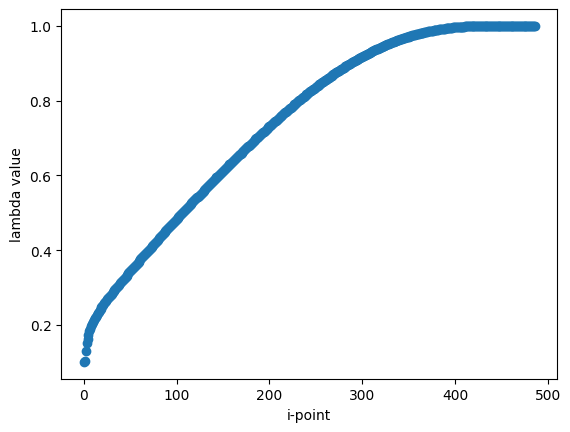

In [ ]:
fig, ax = plt.subplots()
nums = list(range(len(exp_var)))
ax.scatter(nums, cum_exp_var);
ax.set_xlabel('i-point');
ax.set_ylabel('lambda value');

In [ ]:
var_mask = cum_exp_var <= 0.95
sing_values = svd.singular_values_[var_mask]
n_components = sing_values.shape[0]
n_components

327

In [ ]:
svd_with_pc = TruncatedSVD(n_components=n_components)
X_train_reduced = svd_with_pc.fit_transform(X_train)
X_val_reduced = svd_with_pc.transform(X_val)

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

light_boosting_reduced = LGBMClassifier(**params, random_seed=42).fit(X=X_train_reduced, y=y_train,
                                                    eval_set=[(X_val_reduced, y_val)],
                                                    eval_metric='auc')

y_pred_lb_reduced = light_boosting_reduced.predict_proba(X_val_reduced)
print(f'ROC-AUC: {roc_auc_score(y_val, y_pred_lb_reduced[:, 1])}')

ROC-AUC: 0.7109074844280875


# Предсказание для тестовых данных



## Baseline model

Получим предсказание на тестовых данных

In [ ]:
gbdt_clf = HistGradientBoostingClassifier(min_samples_leaf=1,
                                          max_depth=20,
                                          max_iter=125,
                                          random_state=42).fit(X, y)
y_test_pred = gbdt_clf.predict_proba(data_test.drop(['smpl'], axis=1))

y_test_pred = pd.Series(y_test_pred[:, 1])
data_test['target'] = y_test_pred

data_test[['id', 'target']].to_csv('baseline_submission_case1.csv', index=False)

## Our models

### вариант 1 - LightGBM, лучший trial, сырые данные

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

final_model = LGBMClassifier(**params, random_seed=42).fit(X=X, y=y,
                                                    eval_metric='auc')
y_test_pred = final_model.predict_proba(data_test.drop(['smpl'], axis=1))

y_test_pred = pd.Series(y_test_pred[:, 1])
data_test['target'] = y_test_pred

data_test[['id', 'target']].to_csv('baseline_submission_case1.csv', index=False)

### вариант 2: лучшая модель - LightGBM, лучший trial, датасет с удалением нерелевантных

In [ ]:
train_corr_only_whole = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/full train processed/corr_only.csv').drop('Unnamed: 0', axis=1)
test_corr_only_whole = pd.read_csv('/content/drive/MyDrive/Хакатон Альфа-банка. Кейс 1/full test processed/test_corr_only.csv').drop('Unnamed: 0', axis=1)

In [ ]:
train_corr_only_whole

,target,smpl,id,feature_4,feature_5,feature_7,feature_11,feature_16,feature_19,feature_25,...,feature_372_3.0,feature_372_4.0,feature_375_0.0,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_396_1.0,feature_396_2.0
0,0,train,11619,-0.147178,-1.135569,-0.688879,-0.007343,-0.778399,-0.786005,-1.664981,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,train,11620,0.087665,0.316779,-0.143202,-0.507839,0.447524,-0.213129,-1.443812,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,train,11621,3.117520,-1.767073,1.596354,-1.045164,1.782435,1.131342,1.367568,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,train,11622,-0.946474,0.288386,1.049859,0.782964,0.740996,1.055638,-1.362752,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,train,11623,-0.039862,0.305150,-0.157288,0.435065,-0.041253,-0.410871,-0.182347,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38726,0,train,3868,0.113818,-0.709053,0.812546,0.863412,-0.422811,0.116343,0.586546,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38727,0,train,3869,0.940327,-0.465618,0.099768,0.966629,0.103572,-0.116668,0.748177,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38728,0,train,3870,1.212203,0.301982,0.598599,-1.568323,-0.034069,0.086741,-0.393952,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38729,0,train,3871,-0.258802,-0.343323,0.772228,2.008930,-0.338831,-0.099098,-0.245905,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_corr_only_whole

,smpl,id,feature_4,feature_5,feature_7,feature_11,feature_16,feature_19,feature_25,feature_26,...,feature_372_3.0,feature_372_4.0,feature_375_0.0,feature_375_1.0,feature_375_2.0,feature_375_3.0,feature_375_4.0,feature_375_5.0,feature_396_1.0,feature_396_2.0
0,test,48641,-1.950657,-1.069576,-0.901771,-1.604580,-0.943408,-1.273246,-1.329137,-0.649004,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,test,48642,0.116074,0.220002,0.497531,0.624547,0.075499,-1.197486,-1.114676,1.538252,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,test,48643,-0.000365,1.486131,1.074513,0.489753,-0.139380,-1.095204,-0.614853,1.105422,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,test,48644,-1.761253,-1.098213,-0.934671,-0.273109,-0.736389,-1.041397,-0.392141,-0.237954,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,test,48645,2.761329,0.607158,0.392070,0.037941,0.769784,1.177009,0.308806,0.665137,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19821,test,56564,2.433253,0.789014,1.929220,0.531505,1.610211,1.353327,2.718256,2.328821,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19822,test,56565,1.148273,0.279905,-0.392127,-0.526794,1.493749,0.818961,-1.536704,1.488625,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19823,test,56566,-0.241779,-1.099969,-1.535987,-0.447923,-0.514434,-1.464160,-1.993976,-2.022411,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19824,test,56567,-0.728617,-1.042950,-0.778764,-0.997434,-2.624413,-0.134382,-0.263567,-0.265624,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_train_corr_only_whole = train_corr_only_whole.drop(['id', 'target', 'smpl'], axis=1)
y_train_corr_only_whole = train_corr_only_whole['target']
X_test_corr_only_whole = test_corr_only_whole.drop(['id', 'smpl'], axis=1)

In [ ]:
params = {
    'subsample': 0.48748724047206654,
    'learning_rate': 0.033840417964290125,
    'colsample_bytree': 0.5782285251273777,
    'reg_alpha': 0.1351536043430544,
    'reg_lambda': 0.31900045174209063,
    'scale_pos_weight': 5,
    'num_leaves': 27,
    'max_depth': 9,
    'min_child_samples': 99
}

final_model = LGBMClassifier(**params, random_seed=42).fit(X=X_train_corr_only_whole, y=y_train_corr_only_whole,
                                                    eval_metric='auc')

y_test_pred = final_model.predict_proba(X_test_corr_only_whole)

test_corr_only_whole['target'] = pd.Series(y_test_pred[:, 1])

test_corr_only_whole[['id', 'target']].to_csv('submission_case1_corr_only.csv', index=False)

[LightGBM] [Info] Number of positive: 843, number of negative: 37888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27953
[LightGBM] [Info] Number of data points in the train set: 38731, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021766 -> initscore=-3.805423
[LightGBM] [Info] Start training from score -3.805423
